<a href="https://colab.research.google.com/github/caguirre5/Lab9-DL/blob/main/lab09_time_series_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [2]:
data = pd.read_csv('https://drive.google.com/uc?id=16w8ahgJvh1uQifglFatoI05UjLcLDcoO')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


<bound method NDFrame.head of              date  store  sales
0      2013-01-01      1   1316
1      2013-01-01      2   1742
2      2013-01-01      3   1588
3      2013-01-01      4   1423
4      2013-01-01      5   1032
...           ...    ...    ...
18255  2017-12-31      6   2009
18256  2017-12-31      7   1831
18257  2017-12-31      8   3205
18258  2017-12-31      9   2774
18259  2017-12-31     10   2939

[18260 rows x 3 columns]>

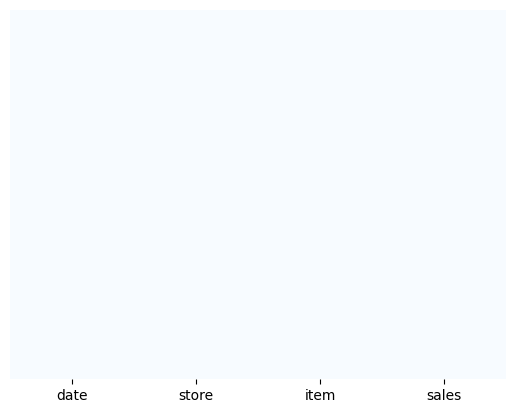

In [3]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap="Blues")
data.isnull().sum()
# Elimina la columna 'item'
data = data.drop(columns=['item'])

# Agrupa por 'date' y 'store' y suma las ventas
data = data.groupby(['date', 'store']).sum().reset_index()

data.head

In [4]:
data.columns

Index(['date', 'store', 'sales'], dtype='object')

date
2013-01-01    1316
2013-01-02    1264
2013-01-03    1305
2013-01-04    1452
2013-01-05    1499
Name: sales, dtype: int64

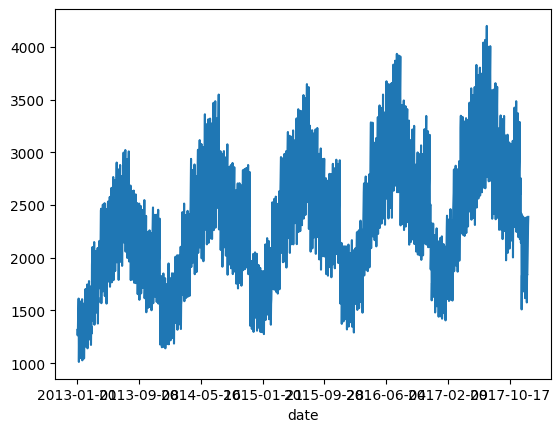

In [5]:
# univariate dataframe: sales vs Time
store_1_data = data[data['store'] == 1]
uni_data_data = store_1_data['sales']
uni_data_data.index = store_1_data['date']
uni_data_data.plot()
uni_data_data.head()

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler  # Agrega esta línea para importar StandardScaler


# Supongamos que 'data' es tu DataFrame original con datos de ventas.
# Asegúrate de que la columna 'date' esté en formato de fecha.
data['date'] = pd.to_datetime(data['date'])

# Divide los datos en conjuntos de entrenamiento, validación y prueba
fecha_fin_prueba = data['date'].max()
fecha_inicio_prueba = fecha_fin_prueba - pd.DateOffset(months=3)
fecha_inicio_validacion = fecha_inicio_prueba - pd.DateOffset(months=6)

conjunto_entrenamiento = data[(data['date'] < fecha_inicio_validacion)]
conjunto_validacion = data[(data['date'] >= fecha_inicio_validacion) & (data['date'] < fecha_inicio_prueba)]
conjunto_prueba = data[(data['date'] >= fecha_inicio_prueba) & (data['date'] <= fecha_fin_prueba)]

# Escala los datos de ventas para tener una media de 0 y desviación estándar de 1
scaler = StandardScaler()
conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
conjunto_prueba['sales'] = scaler.transform(conjunto_prueba['sales'].values.reshape(-1, 1))

# Genera secuencias para el conjunto de entrenamiento y validación
def generar_secuencias(datos, ventana_historica):
    secuencias = []
    for i in range(len(datos) - ventana_historica - 90):  # 90 días para pronosticar 3 meses
        secuencia = datos[i:i+ventana_historica]
        objetivo = datos[i+ventana_historica:i+ventana_historica+90]
        secuencias.append((secuencia, objetivo))
    return secuencias

ventana_historica = 90  # Por ejemplo, una ventana de 90 días para datos diarios.
secuencias_entrenamiento = generar_secuencias(conjunto_entrenamiento['sales'].values, ventana_historica)
secuencias_validacion = generar_secuencias(conjunto_validacion['sales'].values, ventana_historica)
secuencias_prueba = generar_secuencias(conjunto_prueba['sales'].values, ventana_historica)

# Convierte las secuencias en matrices NumPy
X_entrenamiento, y_entrenamiento = zip(*secuencias_entrenamiento)
X_validacion, y_validacion = zip(*secuencias_validacion)
X_prueba, y_prueba = zip(*secuencias_prueba)

X_entrenamiento = np.array(X_entrenamiento).reshape(len(X_entrenamiento), ventana_historica, 1)
y_entrenamiento = np.array(y_entrenamiento)
X_validacion = np.array(X_validacion).reshape(len(X_validacion), ventana_historica, 1)
y_validacion = np.array(y_validacion)
X_prueba = np.array(X_prueba).reshape(len(X_prueba), ventana_historica, 1)
y_prueba = np.array(y_prueba)

# Define el modelo
modelo = Sequential()
modelo.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=False))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo
modelo.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo
modelo.summary()


<ipython-input-6-ad96e3bacafe>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
<ipython-input-6-ad96e3bacafe>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
<ipython-input-6-ad96e3bacafe>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 90)                5850      
                                                                 
Total params: 22746 (88.85 KB)
Trainable params: 22746 (88.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Entrena el modelo
modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1531/1531 [==============================] - 14s 7ms/step - loss: 0.1903 - val_loss: 0.1619
Epoch 2/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.0822 - val_loss: 0.0681
Epoch 3/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.0737 - val_loss: 0.0645
Epoch 4/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.0570 - val_loss: 0.0435
Epoch 5/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.0526 - val_loss: 0.0402
Epoch 6/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.0510 - val_loss: 0.0401
Epoch 7/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.0503 - val_loss: 0.0357
Epoch 8/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.0483 - val_loss: 0.0370
Epoch 9/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.0491 - val_loss: 0.0363
Epoch 10/10
1531/1531 [==============================] - 11s 7ms/step - loss:

In [8]:
print("Tamaño de X_prueba:", X_prueba.shape)
print("Tamaño de y_prueba:", y_prueba.shape)

Tamaño de X_prueba: (750, 90, 1)
Tamaño de y_prueba: (750, 90)


In [9]:
# Evalúa el modelo en el conjunto de prueba
puntuacion = modelo.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación en el conjunto de prueba (MSE):", puntuacion)

24/24 [==============================] - 1s 7ms/step - loss: 0.0641
Puntuación en el conjunto de prueba (MSE): 0.06413661688566208


In [10]:
predicciones = modelo.predict(X_prueba)

24/24 [==============================] - 1s 4ms/step


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones)
mae = mean_absolute_error(y_prueba, predicciones)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 0.13145552266942956
Error Absoluto Medio (MAE): 0.21806706806807666


Vamos a probar modificar el modelo para mejorar nuestros valores de error de MSE y MAE

In [12]:
# Define el modelo mejorado version 1
modelo_v2 = Sequential()

# Primera capa LSTM con dropout
modelo_v2.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo_v2.add(Dropout(0.2))

# Capa GRU con 64 unidades y return_sequences=False
modelo_v2.add(GRU(units=64, return_sequences=False))
modelo_v2.add(Dropout(0.2))
# # Segunda capa LSTM con dropout
# modelo_v2.add(LSTM(units=64, return_sequences=False))
# modelo_v2.add(Dropout(0.3))

modelo_v2.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo mejorado version 1
modelo_v2.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo mejorado version 1
modelo_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 90, 64)            16896     
                                                                 
 dropout_1 (Dropout)         (None, 90, 64)            0         
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 90)                5850      
                                                                 
Total params: 47706 (186.35 KB)
Trainable params: 47706 (186.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
historial = modelo_v2.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1531/1531 [==============================] - 18s 10ms/step - loss: 0.1715 - val_loss: 0.1085
Epoch 2/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0689 - val_loss: 0.0562
Epoch 3/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0568 - val_loss: 0.0461
Epoch 4/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0523 - val_loss: 0.0468
Epoch 5/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0520 - val_loss: 0.0357
Epoch 6/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0500 - val_loss: 0.0349
Epoch 7/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0494 - val_loss: 0.0400
Epoch 8/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0491 - val_loss: 0.0321
Epoch 9/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0486 - val_loss: 0.0332
Epoch 10/10
1531/1531 [==============================] - 15s 10m

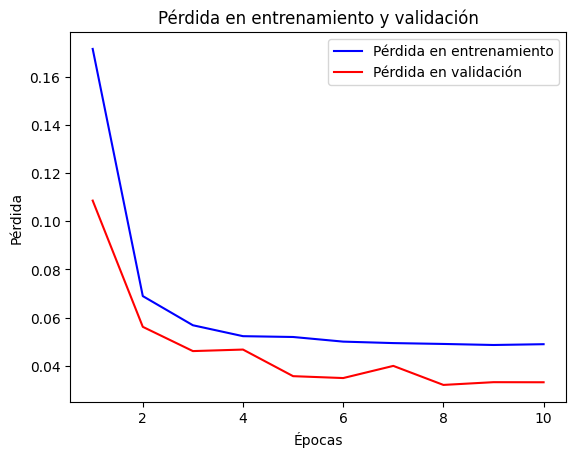

In [14]:
pérdida_entrenamiento = historial.history['loss']
pérdida_validación = historial.history['val_loss']

# Número de épocas
épocas = range(1, len(pérdida_entrenamiento) + 1)

# Graficar las pérdidas
plt.plot(épocas, pérdida_entrenamiento, 'b', label='Pérdida en entrenamiento')
plt.plot(épocas, pérdida_validación, 'r', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [15]:
# Evalúa el modelo en el conjunto de prueba
puntuacion_modelo2 = modelo_v2.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación segundo modelo en el conjunto de prueba (MSE):", puntuacion_modelo2)

24/24 [==============================] - 1s 8ms/step - loss: 0.0591
Puntuación segundo modelo en el conjunto de prueba (MSE): 0.0591401532292366


In [16]:
predicciones_v2 = modelo_v2.predict(X_prueba)

24/24 [==============================] - 1s 6ms/step


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones_v2)
mae = mean_absolute_error(y_prueba, predicciones_v2)

print(f"Error Cuadrático Medio segundo modelo (MSE): {mse}")
print(f"Error Absoluto Medio segundo modelo (MAE): {mae}")

Error Cuadrático Medio segundo modelo (MSE): 0.12151029930386338
Error Absoluto Medio segundo modelo (MAE): 0.2071489830458818


Haremos una tercera version del modelo buscando reducir el error MSE y MAE

In [18]:
# Define el modelo mejorado version 3 (modelo_v3)
modelo_v3 = Sequential()

# Primera capa LSTM con dropout
modelo_v3.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo_v3.add(Dropout(0.2))

# Segunda capa LSTM con dropout
modelo_v3.add(LSTM(units=64, return_sequences=False))
modelo_v3.add(Dropout(0.4))

# # Capa GRU con dropout
# modelo_v3.add(GRU(units=64, return_sequences=False))
# modelo_v3.add(Dropout(0.2))

# # Segunda capa GRU con dropout
# modelo_v3.add(GRU(units=64, return_sequences=False))
# modelo_v3.add(Dropout(0.3))

# Capa de salida
modelo_v3.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo mejorado version 3 (modelo_v3)
modelo_v3.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo mejorado version 3 (modelo_v3)
modelo_v3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 90, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 90)                5850      
                                                                 
Total params: 55770 (217.85 KB)
Trainable params: 55770 (217.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
modelo_v3.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1531/1531 [==============================] - 21s 11ms/step - loss: 0.2254 - val_loss: 0.1636
Epoch 2/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1207 - val_loss: 0.0935
Epoch 3/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0925 - val_loss: 0.0664
Epoch 4/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0842 - val_loss: 0.0641
Epoch 5/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0876 - val_loss: 0.0613
Epoch 6/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0825 - val_loss: 0.0712
Epoch 7/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0811 - val_loss: 0.0586
Epoch 8/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0801 - val_loss: 0.0555
Epoch 9/10
1531/1531 [==============================] - 15s 10ms/step - loss: 0.0804 - val_loss: 0.0609
Epoch 10/10
1531/1531 [==============================] - 14s 9ms

In [20]:
# Evalúa el modelo en el conjunto de prueba
puntuacion_modelo3 = modelo_v3.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación segundo modelo en el conjunto de prueba (MSE):", puntuacion_modelo3)

24/24 [==============================] - 1s 5ms/step - loss: 0.0677
Puntuación segundo modelo en el conjunto de prueba (MSE): 0.06771402806043625


In [21]:
predicciones_v3 = modelo_v3.predict(X_prueba)

24/24 [==============================] - 1s 4ms/step


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones_v3)
mae = mean_absolute_error(y_prueba, predicciones_v3)

print(f"Error Cuadrático Medio tercer modelo (MSE): {mse}")
print(f"Error Absoluto Medio tercer modelo (MAE): {mae}")

Error Cuadrático Medio tercer modelo (MSE): 0.1385105093891669
Error Absoluto Medio tercer modelo (MAE): 0.23896746265496924


En este caso podemos ver que aun volviendo un poco más complejo el modelo no obtenemos un mejor MSE. Por lo tanto trabajaremos en el batch size y epocas del mejor modelo actual, siendo el modelo_v2.

In [23]:
# Define el modelo mejorado version 1
modelo_v2_reloaded = Sequential()

# Primera capa LSTM con dropout
modelo_v2_reloaded.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo_v2_reloaded.add(Dropout(0.2))

# Capa GRU con 64 unidades y return_sequences=False
modelo_v2_reloaded.add(GRU(units=64, return_sequences=False))
modelo_v2_reloaded.add(Dropout(0.2))
# # Segunda capa LSTM con dropout
# modelo_v2_reloaded.add(LSTM(units=64, return_sequences=False))
# modelo_v2_reloaded.add(Dropout(0.3))

modelo_v2_reloaded.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo mejorado version 1
modelo_v2_reloaded.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo mejorado version 1
modelo_v2_reloaded.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 90, 64)            16896     
                                                                 
 dropout_5 (Dropout)         (None, 90, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 90)                5850      
                                                                 
Total params: 47706 (186.35 KB)
Trainable params: 47706 (186.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
modelo_v2_reloaded.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=5, batch_size=1, verbose=1)

Epoch 1/5
15310/15310 [==============================] - 156s 10ms/step - loss: 0.1031 - val_loss: 0.0510
Epoch 2/5
15310/15310 [==============================] - 140s 9ms/step - loss: 0.0564 - val_loss: 0.0367
Epoch 3/5
15310/15310 [==============================] - 144s 9ms/step - loss: 0.0530 - val_loss: 0.0364
Epoch 4/5
15310/15310 [==============================] - 142s 9ms/step - loss: 0.0514 - val_loss: 0.0551
Epoch 5/5
15310/15310 [==============================] - 143s 9ms/step - loss: 0.0507 - val_loss: 0.0358


In [25]:
# Guardar modelo en archivo
from keras.models import load_model

# Guardar el modelo en formato HDF5
modelo_v2_reloaded.save('modelo_v2_reloaded_entrenado.h5')
modelo.save('modelo_entrenado.h5')
modelo_v2.save('modelo_v2_entrenado.h5')
modelo_v3.save('modelo_v3_entrenado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Evalúa el modelo en el conjunto de prueba
puntuacion_modelo2 = modelo_v2_reloaded.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación segundo modelo en el conjunto de prueba (MSE):", puntuacion_modelo2)

24/24 [==============================] - 1s 8ms/step - loss: 0.0563
Puntuación segundo modelo en el conjunto de prueba (MSE): 0.05627156049013138


In [27]:
predicciones_v2 = modelo_v2_reloaded.predict(X_prueba)

24/24 [==============================] - 1s 5ms/step


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones_v2)
mae = mean_absolute_error(y_prueba, predicciones_v2)

print(f"Error Cuadrático Medio segundo modelo (MSE): {mse}")
print(f"Error Absoluto Medio segundo modelo (MAE): {mae}")

Error Cuadrático Medio segundo modelo (MSE): 0.1151689648016361
Error Absoluto Medio segundo modelo (MAE): 0.20794611524615092


Luego de realizar todos estos cambios de arquitecturas de modelo, parametros e híperparametros por lo que de momento el modelo final que estaremos utilizando será la versión 2 del mismo. Ahora graficaremos las predicciones vs los valores reales.

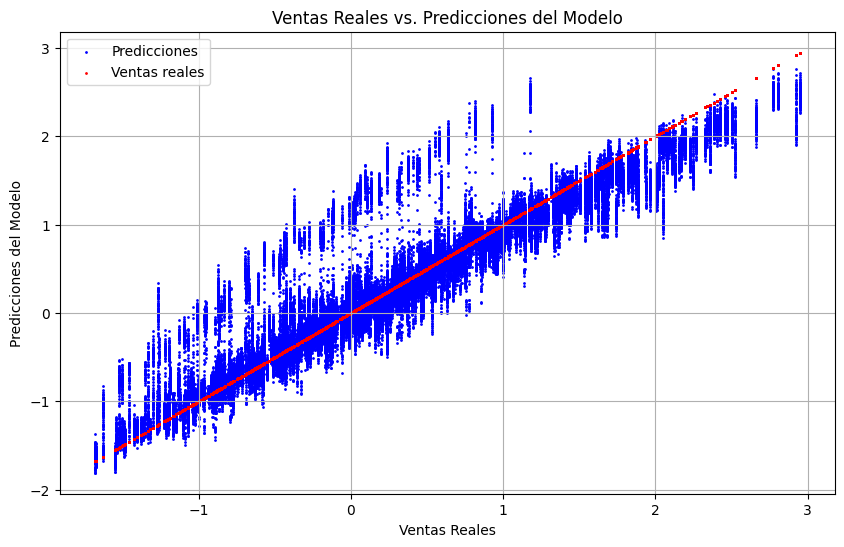

In [29]:
# Crear un gráfico de dispersión (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_prueba, predicciones_v2, c='blue', label='Predicciones',s=1)  # Pintar las predicciones de azul con marcadores de "x"
plt.scatter(y_prueba, y_prueba, c='red', label='Ventas reales',s=1)  # Pintar los valores reales de rojo con marcadores de "o"
plt.xlabel('Ventas Reales')
plt.ylabel('Predicciones del Modelo')
plt.title('Ventas Reales vs. Predicciones del Modelo')
plt.legend()
plt.grid(True)

plt.show()

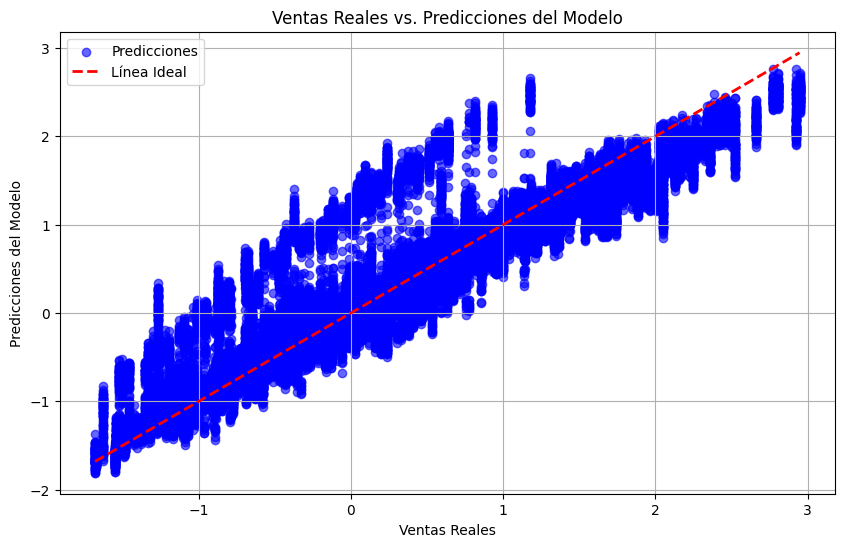

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_prueba, predicciones_v2, c='blue', label='Predicciones', marker='o', alpha=0.6)
plt.plot([np.min(y_prueba), np.max(y_prueba)], [np.min(y_prueba), np.max(y_prueba)], linestyle='--', color='red', linewidth=2, label='Línea Ideal')
plt.xlabel('Ventas Reales')
plt.ylabel('Predicciones del Modelo')
plt.title('Ventas Reales vs. Predicciones del Modelo')
plt.legend()
plt.grid(True)

plt.show()

Ahora en cuanto a temas de interpretabilidad del modelo con SHAP

In [31]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.6 MB/s eta 0:00:00


In [32]:
modelo_v2

In [33]:
import shap
# explainer = shap.Explainer(modelo_v2, masker=shap.maskers.Independent)
explainer = shap.Explainer(modelo_v2)

ValueError: ignored

In [ ]:
shap_values = explainer.shap_values(X_entrenamiento)

In [ ]:
shap.summary_plot(shap_values, features=X_entrenamiento, show=False)